In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [4]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

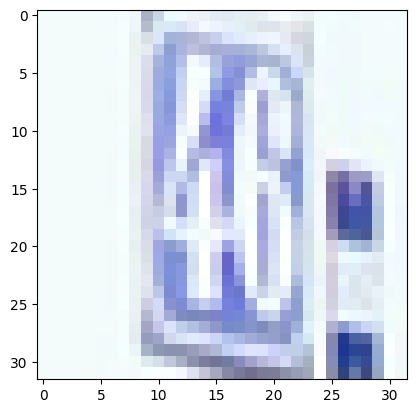

In [5]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

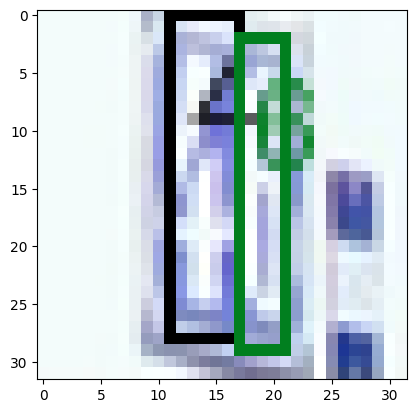

In [10]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [11]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [12]:
len(dataloader)

1

In [13]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]]), tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]])]
tensor([[0.4533, 0.4565, 0.1963, 0.8696],
        [0.6075, 0.5000, 0.1495, 0.8696]])


NameError: name 'anchors' is not defined

In [14]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [15]:
import json

In [18]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment2.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=250,
    lr=3e-3,
    batch_size=64,
    lambda_coord=0.05,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 250/250 [00:31<00:00,  7.81it/s, class_loss=0.000115, conf_loss=0.00861, coord_loss=0.000235, loss=0.00896]


[4.237380027770996,
 3.8620736598968506,
 3.577378273010254,
 3.361248731613159,
 3.171163558959961,
 2.9990651607513428,
 2.8369345664978027,
 2.6770408153533936,
 2.5234155654907227,
 2.3755412101745605,
 2.2305381298065186,
 2.0886406898498535,
 1.9467837810516357,
 1.8106889724731445,
 1.6739248037338257,
 1.551800012588501,
 1.4411200284957886,
 1.3373368978500366,
 1.241340160369873,
 1.1499813795089722,
 1.0654582977294922,
 0.9885796904563904,
 0.9162728786468506,
 0.8516891002655029,
 0.7883914113044739,
 0.7029836773872375,
 0.5748793482780457,
 0.43877971172332764,
 0.5310057401657104,
 0.33730143308639526,
 0.32307159900665283,
 0.3047856390476227,
 0.2673504948616028,
 0.22866085171699524,
 0.20248526334762573,
 0.18167546391487122,
 0.16394536197185516,
 0.15221592783927917,
 0.14193397760391235,
 0.13449931144714355,
 0.1251368373632431,
 0.11213429272174835,
 0.1055484414100647,
 0.098044253885746,
 0.08839250355958939,
 0.08499671518802643,
 0.08071466535329819,
 0.075

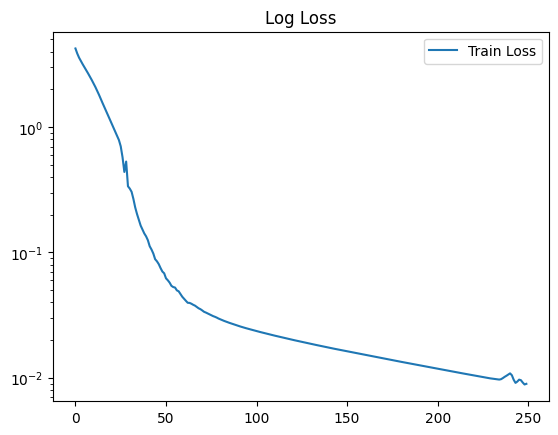

In [19]:
trainer.train()

In [20]:
pred = model(batch["images"])
pred.shape

torch.Size([2, 8, 8, 30])

In [21]:
pred[0, 0, 0, :], pred[0, 1, 1, :]

(tensor([-2.6441, -5.8607, -0.9783, -0.9358, -6.9977, -3.7873, -3.3248, -5.9987,
         -2.9393,  1.9041, -2.2704, -1.5385,  2.6197, -4.5072,  2.4081,  0.7280,
         -2.1601,  3.8518,  2.2556, -8.4334, -1.6914, -2.0294, -1.9620, -1.7908,
         -0.9955, -1.2437, -4.5200, -0.8998, -1.8342, -4.5104],
        grad_fn=<SliceBackward0>),
 tensor([ -1.4434,  -6.8793,   0.0505,  -0.0793,  -9.7199,  -5.1618,  -0.7376,
          -5.0574,  -4.9618,  -0.1618,  -3.9022,   0.0689,   2.0250,  -6.5066,
          -0.3451,   6.0562,  -1.3407,   2.9400,   8.1228, -11.2949,  -4.4852,
          -3.9432,   1.8130,  -5.4489,  -2.5306,   2.4927,   1.5243,  -3.3283,
           1.2768,  -4.3796], grad_fn=<SliceBackward0>))

In [26]:
i = 1

In [27]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.6074, 0.5000, 0.1496, 0.8866],
          [0.4535, 0.4572, 0.1985, 0.8621]]),
  'confidence': tensor([0.7081, 0.7058]),
  'labels': tensor([6, 4]),
  'scores': tensor([0.9995, 0.9998])},
 {'bboxes': tensor([[0.5890, 0.5319, 0.1650, 0.7256],
          [0.4397, 0.5000, 0.1962, 0.7050]]),
  'confidence': tensor([0.8386, 0.8134]),
  'labels': tensor([1, 7]),
  'scores': tensor([0.9998, 0.9999])}]

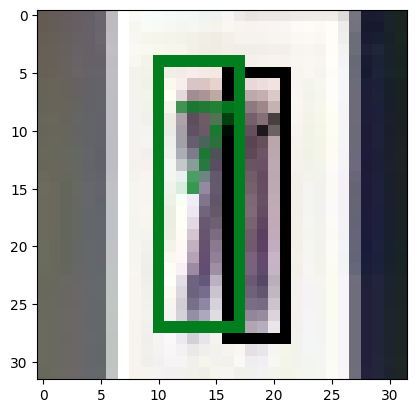

In [28]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

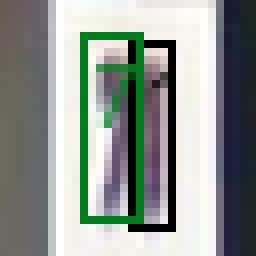

In [29]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [83]:
calculate_mAP(
    model,
    trainer.train_loader,
)

100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


{'map': 1.0,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 1.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 1.0,
 'mar_10': 1.0,
 'mar_100': 1.0,
 'mar_small': 1.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}